### Reproducing Fig4C with Matlab Code

In [1]:
import sys
sys.path.append("../../")

# spectrome imports:
from spectrome.forward import runforward
from spectrome.utils import functions, path, generate
from spectrome.brain import Brain

# Other modules:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm_notebook

In [2]:
# An external custom function for re-arranging the individual connectomes to match the Desikan-Killiany atlas brain regions indexing.

def individual_connectome_order():
    """Get individual connectome's brain region ordering (specific for DK86 atlas).

    Args:

    Returns:
        perm (type): Brain region orders for all regions
        empty (type): Brain regions with no MEG
        cort (type): Brain cortical regions.

    """
    cort_lh = np.array([0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 13, 14,
                             15, 17, 16, 18, 19, 20, 21, 22, 23, 24, 25,
                             26, 27, 28, 29, 30, 31, 5, 32, 33, 9])
    qsubcort_lh = np.array([0, 40, 36, 39, 38, 37, 35, 34, 0])
    qsubcort_rh = qsubcort_lh + 34 + 1
    cort = np.concatenate([cort_lh, 34 + cort_lh])
    cort_rh = cort_lh + 34 + 7
    perm = np.concatenate([cort_lh, cort_rh,
                                qsubcort_lh, qsubcort_rh])
    empty = np.array([68, 77, 76, 85])
    return perm, empty, cort

# external function from matlab:
def get_mean_C(C):
    #C = np.mean(C, axis = 2)
    C = (C + np.transpose(C))/2
    
    ss = np.argsort(-C[:])
    C = np.minimum(C, ss[int(np.round(0.01*len(ss)))])
    return C

# simulate random connectome:
def random_WCij_und(V, E):
    # upper triangle of zeros:
    zmat = np.triu(np.ones(V))
    np.fill_diagonal(zmat, 0)
    S = zmat.shape # shape for unraveling later
    linear_indices = np.squeeze(np.asarray(zmat.ravel().nonzero()))

    current_E = len(linear_indices)*2
    while current_E > E:
        loc = np.unravel_index(np.random.choice(linear_indices, replace = False), S)
        zmat[loc] = 0
        current_E = np.count_nonzero(zmat)*2

    zmat = zmat + np.transpose(zmat)
    #scale by distance metric:
    #dist_ind = np.asarray(np.nonzero(np.triu(Dist)))
    #dist_dist = Dist[dist_ind[0,:], dist_ind[1,:]]
    
    #z_ind = np.asarray(np.nonzero(np.triu(zmat)))
    #for i in np.arange(0,z_ind.shape[1]):
    #    zmat[z_ind[0,i], z_ind[1,i]] = np.random.choice(np.squeeze(dist_dist))
    
    rmat = np.random.random([V,V])*100
    Cijw = np.multiply(zmat, rmat)
    #Cijw = zmat + np.transpose(zmat)
    return Cijw

# new distance matrix:
# new function to create distance matrix:
def exp_neg_dist_Cij(distance_matrix, sparsity = 0.8):
    """Generate network weighted by exponent of negative distance given sparsity:
    
    Args:
        distance_matrix (array): input distance matrix
    
    Returns:
        negdist [array]: symmetric distance weighted network with 0 diagonal
    """
    negdist = np.exp(-distance_matrix)
    negdist = negdist - np.diag(np.diag(negdist))

    V = len(negdist)  # number of vertices
    #compute current sparsity:
    current_sparsity = np.count_nonzero(negdist == 0)/(len(negdist)**2)

    # Remove lowest distances to achieve sparsity:
    while current_sparsity < sparsity:
        triu_negdist = np.triu(negdist)
        triu_nonzeros = np.asarray(np.triu(negdist).ravel().nonzero())
        # replace lowest distances with 0's
        min_loc = np.where(triu_negdist == np.amin(triu_negdist[np.unravel_index(triu_nonzeros, negdist.shape)]))
        triu_negdist[min_loc[0]] = 0
        #update sparsity:
        negdist = triu_negdist + np.transpose(triu_negdist)
        current_sparsity = np.count_nonzero(negdist == 0)/(len(negdist)**2)

    return negdist

In [3]:
# define data directory
data_dir = path.get_data_path()

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,68)

# define frequency bins:
fmin = 2
fmax = 45
fvec = np.linspace(fmin, fmax, 40) # 40 frequency bins between 2Hz-45Hz

# filter coefficients for smoothing
lpf = np.array([1, 2, 5, 2, 1])
lpf = lpf/np.sum(lpf)

#tempalte brain:
hcp_brain = Brain.Brain()
hcp_brain.add_connectome(data_dir)
hcp_brain.reorder_connectome(hcp_brain.connectome, hcp_brain.distance_matrix)
hcp_brain.bi_symmetric_c()
hcp_brain.reduce_extreme_dir()

In [5]:
## Load MEG:
## individual connectomes, this is a Nregion x Nregion x Nsubjects array:
ind_data = loadmat(data_dir + '/individual_subjects.mat')
ind_cdk = ind_data['A_all_subjs_final']
perm, empty, cort = individual_connectome_order()

## individual optimization results:
ind_optr = loadmat(data_dir + '/SCFC_opparam_individual.mat')
# extract the spectral correlation values:
nsubs = ind_optr['output']['feval'].shape[1]

# extract parameters for use later:
ind_params = np.zeros([nsubs, 7])
for i, params in enumerate(np.squeeze(ind_optr['output']['param'])):
    if ind_optr['output']['param'][0,i].shape[1] == 1:
        ind_params[i] = np.squeeze(params)

ind_params = ind_params[~np.all(ind_params == 0, axis=1)] #remove 3 subjects again
print(ind_params.shape)

## individual MEG frequency spectrum:
ind_freq = loadmat(data_dir + '/freqMEGdata.mat')
ind_psd = np.zeros([np.squeeze(ind_freq['freqMEGdata']['psd'])[0].shape[0], len(fvec), nsubs])
empty_psd = np.zeros(3)
e = 0
for i, psd in enumerate(np.squeeze(ind_freq['freqMEGdata']['psd'])):
    if psd.shape[1] != 0:
        # smooth
        for q in np.arange(0,len(psd)):
            ind_psd[q,:,i] = np.convolve(psd[q,:], lpf, 'same')
            ind_psd[q,:,i] = np.sqrt(np.abs(ind_psd[q,:,i]))
            ind_psd[q,:,i] = ind_psd[q,:,i] - np.mean(ind_psd[q,:,i])
        
    else:
        empty_psd[e] = i
        e += 1

ind_psd = np.delete(ind_psd, empty_psd, axis = 2)
print(ind_psd.shape) # Nbins x Nregions x Nsubjects
nsubs = ind_params.shape[0]

(36, 7)
(68, 40, 36)


/home/rajlab/miniconda3/envs/jupyterhub_36/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


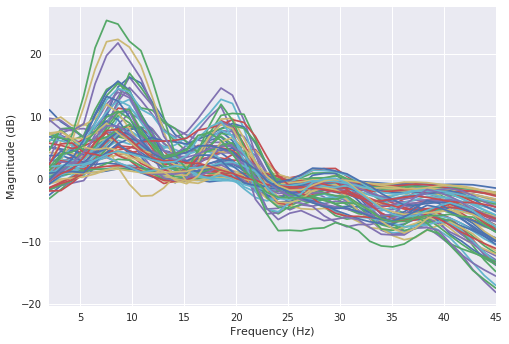

In [6]:
# Plot the source localized MEG spectra:
with plt.style.context('seaborn'):
    plt.plot(fvec, np.transpose(ind_psd[:,:,0]))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.autoscale(enable=True, axis='x', tight='True')

Compute Model Frequency Profile:

In [7]:
ri_corr = np.zeros(nsubs)

for s in tqdm_notebook(np.arange(0, nsubs), desc = 'Optimized Parameters'):
    C_ind = ind_cdk[:,:,s] # grab current subject's individual connectome
    F_ind = ind_psd[:,:,s] # grab current subject's MEG

    # permute to fix ordering:
    C_ind = C_ind[perm,:][:,perm]
    C_ind[empty,:] = 0
    C_ind[:,empty] = 0

    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    brain.connectome = C_ind # re-assign connectome to individual connectome
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brain.distance_matrix = get_mean_C(brain.distance_matrix)
    # re-assigne optimized parameters:
    brain.ntf_params['tau_e'] = ind_params[s,0]
    brain.ntf_params['tau_i'] = ind_params[s,1]
    brain.ntf_params['alpha'] = ind_params[s,2]
    brain.ntf_params['speed'] = ind_params[s,3]
    brain.ntf_params['gei'] = ind_params[s,4]
    brain.ntf_params['gii'] = ind_params[s,5]
    brain.ntf_params['tauC'] = ind_params[s,6]

    # simulate model spectra:
    freq_mdl, freq_resp, _, _ = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)
    freq_mdl = freq_mdl[rois_with_MEG,:]
    # smooth out spectra
    # smooth out spectra
    freq_out = np.zeros(freq_mdl.shape)
    for p in np.arange(0,len(freq_mdl)):
        freq_out[p,:] = np.convolve(np.abs(freq_mdl[p,:]), lpf, 'same')
        freq_out[p,:] = np.sqrt(np.abs(freq_out[p,:]))
        freq_out[p,:] = freq_out[p,:] - np.mean(freq_out[p,:])
        #freq_out[p,:] = functions.mag2db(np.abs(freq_mdl[p,:]))
        #freq_out[p,:] = functions.mag2db(np.convolve(np.abs(freq_mdl[p,:]), lpf, 'same'))
        #freq_out[p,:] = np.convolve(np.abs(freq_mdl[p,:]), lpf, 'same')
                                         
    corrs = np.zeros(len(freq_out))
    for c in np.arange(0, len(freq_out)):
        corrs[c] = pearsonr(ind_psd[c,:,s], freq_out[c,:])[0]

    ri_corr[s] = np.mean(corrs)

/home/rajlab/miniconda3/envs/jupyterhub_36/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
num_it = 25 # 25 iterations x 36 parameters = 900 simulations total
r80_corr = np.zeros([num_it, nsubs])
brain = Brain.Brain()
DD = exp_neg_dist_Cij(hcp_brain.distance_matrix, sparsity = 0.8)
for r in tqdm_notebook(np.arange(0, num_it), desc = 'Random connectomes'):
    for s in np.arange(0, nsubs):
        # create spectrome brain:
        #np.random.seed(s*r)
        brain.add_connectome(data_dir) # grabs distance matrix
        
        # Create random connectivity matrix:
        V = 86 # number of nodes
        E = np.floor((V ** 2)*(1-0.80)) # sparsity on number of edges: 80
        brain.reducedConnectome = random_WCij_und(V, E)
        brain.distance_matrix = generate.distance_matrix(brain.connectome, brain.distance_matrix)
        brain.distance_matrix = get_mean_C(brain.distance_matrix)
        # simulate model spectra:
        brain.ntf_params['tau_e'] = ind_params[s,0]
        brain.ntf_params['tau_i'] = ind_params[s,1]
        brain.ntf_params['alpha'] = ind_params[s,2]
        brain.ntf_params['speed'] = ind_params[s,3]
        brain.ntf_params['gei'] = ind_params[s,4]
        brain.ntf_params['gii'] = ind_params[s,5]
        brain.ntf_params['tauC'] = ind_params[s,6]
        freq_mdl, freq_resp, _, _ = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)
        freq_mdl = freq_mdl[rois_with_MEG,:]

        # smooth out spectra
        freq_out = np.zeros(freq_mdl.shape)
        for p in np.arange(0,len(freq_mdl)):
            freq_out[p,:] = np.convolve(np.abs(freq_mdl[p,:]), lpf, 'same')
            freq_out[p,:] = np.sqrt(np.abs(freq_out[p,:]))
            freq_out[p,:] = freq_out[p,:] - np.mean(freq_out[p,:])
            
        corrs = np.zeros(len(freq_out))
        for c in np.arange(0, len(freq_out)):
            corrs[c] = pearsonr(ind_psd[c,:,s], freq_out[c,:])[0]
        
        r80_corr[r,s] = np.mean(corrs)

/home/rajlab/miniconda3/envs/jupyterhub_36/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


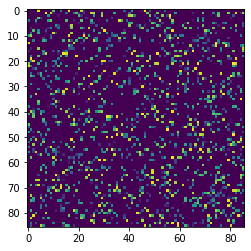

In [9]:
plt.imshow(brain.reducedConnectome)

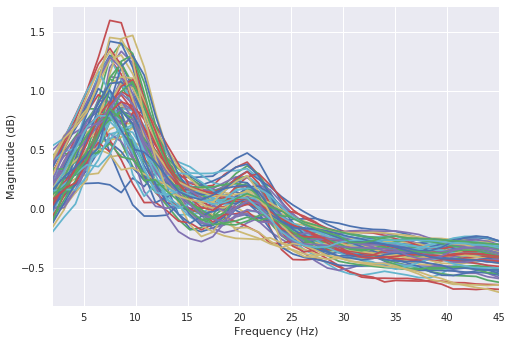

In [10]:
# Plot the source localized MEG spectra:
with plt.style.context('seaborn'):
    plt.plot(fvec, np.transpose(freq_out))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.autoscale(enable=True, axis='x', tight='True')

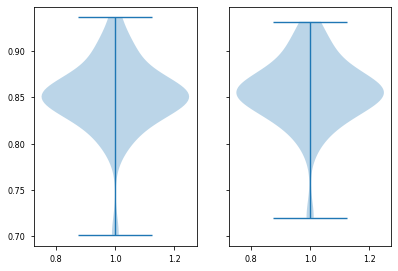

In [11]:
r80_mean = np.mean(r80_corr, axis = 0)
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1,2, sharey=True)
    ax[0].violinplot(ri_corr)
    ax[1].violinplot(r80_mean)

## Distance Connectome:

In [12]:
num_it = 1
dist_corr = np.zeros([num_it, nsubs])
# create spectrome brain:
brain = Brain.Brain()
brain.add_connectome(data_dir) # grabs distance matrix
brain.reorder_connectome(brain.connectome, brain.distance_matrix)

# Sample distance metrics for random matrix:
brain.reducedConnectome = exp_neg_dist_Cij(brain.distance_matrix, sparsity = 0.80)
brain.distance_matrix = generate.distance_matrix(brain.reducedConnectome, brain.distance_matrix)

for r in tqdm_notebook(np.arange(0, num_it), desc = 'Distance connectomes'):
    for s in np.arange(0, nsubs):
        # simulate model spectra:
        brain.ntf_params['tau_e'] = ind_params[s,0]
        brain.ntf_params['tau_i'] = ind_params[s,1]
        brain.ntf_params['alpha'] = ind_params[s,2]
        brain.ntf_params['speed'] = ind_params[s,3]
        brain.ntf_params['gei'] = ind_params[s,4]
        brain.ntf_params['gii'] = ind_params[s,5]
        brain.ntf_params['tauC'] = ind_params[s,6]
        freq_d, freq_resp, _, _ = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)
        freq_d = freq_d[rois_with_MEG,:]
        # smooth out spectra
        freq_dout = np.zeros(freq_d.shape)
        for p in np.arange(0,len(freq_d)):
            #freq_dout[p,:] = np.convolve(np.abs(freq_d[p,:]), lpf, 'same')
            #freq_dout[p,:] = functions.mag2db(freq_dout[p,:])
            #freq_out[p,:] = np.abs(freq_mdl[p,:])
            #freq_dout[p, np.nonzero(freq_dout[p,:] ==0)] = np.spacing(1000000)
            #freq_dout[p,:] = functions.mag2db(freq_dout[p,:])
            #freq_out[p, np.isinf(freq_out[p,:])] = np.spacing(1)
            freq_dout[p,:] = np.convolve(np.abs(freq_d[p,:]), lpf, 'same')
            freq_dout[p,:] = np.sqrt(np.abs(freq_dout[p,:]))
            freq_dout[p,:] = freq_dout[p,:] - np.mean(freq_dout[p,:])
            
        corrs = np.zeros(len(freq_dout))
        for c in np.arange(0, len(freq_dout)):
            corrs[c] = pearsonr(ind_psd[c,:,s], freq_dout[c,:])[0]
        
        dist_corr[r,s] = np.mean(corrs)

/home/rajlab/miniconda3/envs/jupyterhub_36/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


/media/rajlab/sachin_data_1/userdata/xihe/spectrome/spectrome/forward/network_transfer.py:214: RuntimeWarning: divide by zero encountered in true_divide
  FCmodel = np.matmul(np.matmul(np.diag(1 / den), FCmodel), np.diag(1 / den))
/media/rajlab/sachin_data_1/userdata/xihe/spectrome/spectrome/forward/network_transfer.py:214: RuntimeWarning: invalid value encountered in matmul
  FCmodel = np.matmul(np.matmul(np.diag(1 / den), FCmodel), np.diag(1 / den))


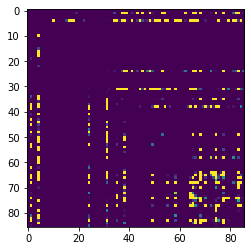

In [13]:
plt.imshow(brain.reducedConnectome)

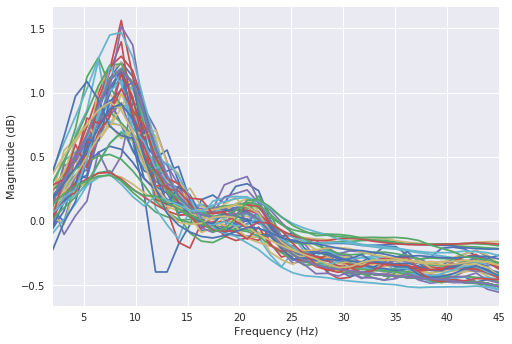

In [14]:
# Plot the source localized MEG spectra:
with plt.style.context('seaborn'):
    plt.plot(fvec, np.transpose(freq_dout))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.autoscale(enable=True, axis='x', tight='True')

In [15]:
print('Sparsity is approximately ' + str(np.around(np.count_nonzero(brain.reducedConnectome)/(86**2),3)))

Sparsity is approximately 0.19


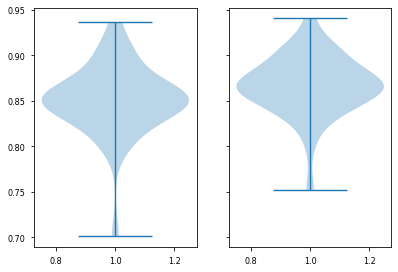

In [16]:
dst_mean = np.mean(dist_corr, axis = 0)
with plt.style.context('seaborn-paper'):
    df, da = plt.subplots(1,2, sharey=True)
    da[0].violinplot(ri_corr)
    da[1].violinplot(dst_mean)

In [17]:
avg_corr = np.zeros(nsubs)

brain.ntf_params['tau_e'] = np.mean(ind_params[:,0])
brain.ntf_params['tau_i'] = np.mean(ind_params[:,1])
brain.ntf_params['alpha'] = np.mean(ind_params[:,2])
brain.ntf_params['speed'] = np.mean(ind_params[:,3])
brain.ntf_params['gei'] = np.mean(ind_params[:,4])
brain.ntf_params['gii'] = np.mean(ind_params[:,5])
brain.ntf_params['tauC'] = np.mean(ind_params[:,6])

for s in tqdm_notebook(np.arange(0, nsubs), desc = 'Average Parameters'):
    C_ind = ind_cdk[:,:,s] # grab current subject's individual connectome
    F_ind = ind_psd[:,:,s] # grab current subject's MEG

    # permute to fix ordering:
    C_ind = C_ind[perm,:][:,perm]
    C_ind[empty,:] = 0
    C_ind[:,empty] = 0

    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    brain.connectome = C_ind # re-assign connectome to individual connectome
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
    brain.distance_matrix = get_mean_C(brain.distance_matrix)

    # simulate model spectra:
    freq_a, freq_resp, _, _ = runforward.run_local_coupling_forward(brain, brain.ntf_params, fvec)
    freq_a = freq_a[rois_with_MEG,:]
    # smooth out spectra
    # smooth out spectra
    freq_aout = np.zeros(freq_a.shape)
    for p in np.arange(0,len(freq_a)):
        freq_aout[p,:] = np.convolve(np.abs(freq_a[p,:]), lpf, 'same')
        freq_aout[p,:] = np.sqrt(np.abs(freq_aout[p,:]))
        freq_aout[p,:] = freq_aout[p,:] - np.mean(freq_aout[p,:])

    corrs = np.zeros(len(freq_aout))
    for c in np.arange(0, len(freq_aout)):
        corrs[c] = pearsonr(ind_psd[c,:,s], freq_aout[c,:])[0]

    avg_corr[s] = np.mean(corrs)

/home/rajlab/miniconda3/envs/jupyterhub_36/lib/python3.6/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


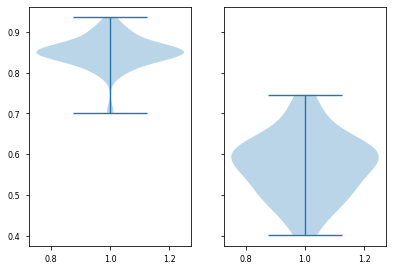

In [18]:
with plt.style.context('seaborn-paper'):
    af, aa = plt.subplots(1,2, sharey=True)
    aa[0].violinplot(ri_corr)
    aa[1].violinplot(avg_corr)

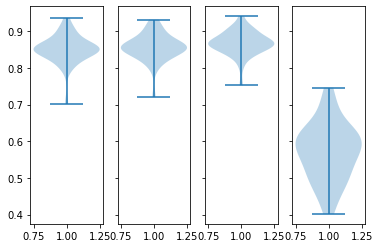

In [19]:
fig, ax = plt.subplots(1,4, sharey = True)
ax[0].violinplot(ri_corr);
ax[1].violinplot(r80_mean);
ax[2].violinplot(dst_mean);
ax[3].violinplot(avg_corr);